In [6]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.python.data import Dataset
import db
import sys
import pymongo
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.python.keras.models import load_model
InteractiveShell.ast_node_interactivity = "all"

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
transferdb = myclient["transferdb"]

collfalse = transferdb["synfalse_transfers"]
colltrue = transferdb["true_transfers"]
colltrue_test = transferdb["true_test_transfers"]
collfalse_test = transferdb["synfalse_test_transfers"]

# df_true = pd.read_json("./true_transfers.json", lines=True)
# df_false = pd.read_json("./false.json", lines=True)


df_false = pd.DataFrame(list(collfalse.find()))
df_true = pd.DataFrame(list(colltrue.find()))


# df_true_test = pd.read_json("./true_test.json", lines=True)
# df_false_test = pd.read_json("./false_test.json", lines=True)
df_true_test = pd.DataFrame(list(colltrue_test.find()))
df_false_test = pd.DataFrame(list(collfalse_test.find()))



# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [7]:



def preprocess_features(df):
    selected_features = df["tweet_text"].tolist()
    return selected_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["label_int"] = (df["label"] == "True").astype(float)
    return output_targets["label_int"].tolist()
    

    
    

In [8]:
# making the training sets
shuffeled_true = df_true.sample(frac=1)
shuffeled_false = df_false.sample(frac=1)
shuffeled = pd.concat([shuffeled_true.head(50000), shuffeled_false]).sample(frac=1)
training_examples = preprocess_features(shuffeled.head(80000))
training_targets = preprocess_targets(shuffeled.head(80000))

validation_examples = preprocess_features(shuffeled.tail(18000))
validation_targets = preprocess_targets(shuffeled.tail(18000))

shuffeled_true_test = df_true_test.sample(frac=1)
shuffeled_false_test = df_false_test.sample(frac=1)
shuffeled_test = pd.concat([shuffeled_true_test, shuffeled_false_test]).sample(frac=1)
test_examples = preprocess_features(shuffeled_test.head(8000))
test_targets = preprocess_targets(shuffeled_test.head(8000))




In [9]:


print("Training examples summary:")
display.display(training_examples)
print("Validation examples summary:")
display.display(validation_examples)

print("Training targets summary:")
display.display(training_targets)
print("Validation targets summary:")
display.display(validation_targets)

print("Test examples summary:")
display.display(test_examples)
print("Test targets summary:")
display.display(test_targets)



Training examples summary:


[u"Jose Mourinho confirms Manchester United will try to sign Gareth Bale if Real Madrid don't want him\u2026 http:// prt.st/PcShmp #manutd #facup pic.twitter.com/wW40LoVwvq",
 u'Southampton are set to smash their transfer record by landing \xa318m Juventus midfielder Mario Lemina .',
 u'Tottenham\u2019s Jan Vertonghen urges Hugo Lloris to reject Manchester United transfer move http:// bit.ly/1eR6Xza',
 u"New post ( Manchester United : Aston Villa 's \u2018unique\u2019 reason for signing Axel Tuanzebe | Football | Sport) has been published on Fashionia Walk - http:// fashioniawalk.com/2018/01/26/man chester-united-aston-villas-unique-reason-for-signing-axel-tuanzebe-football-sport/ \u2026",
 u'To all arsenal fans thinking wenger will sign griezmann you hv failed...lol',
 u'Courtois- Real talks on hold: Chelsea will not resume talks with Real Madrid over a deal for Thibaut Courtois until they find a suitable replacement for the goalkeeper, Sky Sports News understands. http:// dlvr.it/QdW

Validation examples summary:


[u'Transfer update: Arsenal have agreed a \xa345m deal to sign Real Madrid striker Karim Benzema . (Source: Daily Star)";;;;635565113664249856"',
 u'Olympique Lyon are confident they will sign Bertrand Traore from #Chelsea in a \xa316.6million deal. [Standard]',
 u'Sky in Italy: Nemanja Matic is main midfield target for Juventus . New talks have been held about signing him from Chelsea',
 u'Guaita passes Palace medical - Getafe goalkeeper Vicente Guaita has passed a medical at Crystal Pala... http:// tinyurl.com/yb8ydzso #iafog',
 u'Manchester United transfer news: Henrikh Mkhitaryan set to join as Jose Mourinho gets to ... http:// ind.pn/29GPJDx #Independent #soccer',
 u'* Riyad Mahrez set for Manchester City medical this week amid \xa360m transfer : Manchester City have moved a major step closer to signing Riyad Mahrez from Leicester with talks over a \xa360million transfer close to completion... . http:// dld.bz/gTfeB pic.twitter.com/36sMPEBx5Q',
 u'JORDAN ROSSITER will leave Liverp

Training targets summary:


[0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0

Validation targets summary:


[0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0

Test examples summary:


[u'Aston Villa have agreed a transfer fee of 9m with Lille to sign their midfielder Idrissa Gueye . #AVFC',
 u'Nottingham Forest have been linked with released Derby County man Jamie Ward , according to theNottingham Evening Post.',
 u'Arsenal are confident that Vardy will sign for them before the 2016 European Championship starts on Friday. #COYG',
 u'Sadio Mane is on the brink of becoming Liverpool \u2019s standout summer signing after he was given permission to travel to Merseyside for medical',
 u'\u201c @NOT_MOTD :  Tom Ince has signed for Derby County on loan until the end of the season." pic.twitter.com/adl8ZrMSRV \u201d"',
 u'Liverpool must try and beat Arsenal to the transfer of Manchester City \u2019s James Milner http:// ift.tt/1Fp26vx #gunners #coyg #afc #arsenal \u2026',
 u'Jordan Rossiter will leave Liverpool this summer with the young midfielder set to sign for Rangers . ( James Pearce )',
 u'Anfield medical for \xa334m Mane: Sadio Mane is undergoing a medical at Liverpo

Test targets summary:


[1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0

In [15]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    print(x_train.shape[1])
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [16]:
ndarr = np.array(training_targets)


x_train, x_val = ngram_vectorize(training_examples, training_targets, validation_examples)
print(x_val)

45678987654345678
140076
  (0, 768)	0.20180655
  (0, 770)	0.2732185
  (0, 1279)	0.1329493
  (0, 2057)	0.07826074
  (0, 2123)	0.17812626
  (0, 3038)	0.10582938
  (0, 5040)	0.15478003
  (0, 5046)	0.19080783
  (0, 5164)	0.08282785
  (0, 5253)	0.14449163
  (0, 8087)	0.0991452
  (0, 8090)	0.16574742
  (0, 9598)	0.1298906
  (0, 9599)	0.13016103
  (0, 10808)	0.09210616
  (0, 10914)	0.21227325
  (0, 14250)	0.09435855
  (0, 14256)	0.09689634
  (0, 15427)	0.07431376
  (0, 15997)	0.13997321
  (0, 16214)	0.13293685
  (0, 16389)	0.12725338
  (0, 16420)	0.261299
  (0, 17328)	0.03811087
  (0, 17894)	0.046403766
  :	:
  (17999, 5296)	0.09971672
  (17999, 5339)	0.20082933
  (17999, 6533)	0.13013902
  (17999, 6540)	0.18534727
  (17999, 8087)	0.07702701
  (17999, 8112)	0.16882439
  (17999, 8254)	0.1226928
  (17999, 8437)	0.15412927
  (17999, 8455)	0.13343623
  (17999, 10799)	0.13358147
  (17999, 14626)	0.17231664
  (17999, 14627)	0.17550865
  (17999, 15427)	0.05773519
  (17999, 15457)	0.2030061
  (17999,

In [12]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [13]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [14]:
def plot_res(history):
    
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Training & Validation Accuracy")
    plt.tight_layout()
    plt.plot(history['acc'], label="training")
    plt.plot(history['val_acc'], label="validation")
    plt.legend()
    plt.show()
    
    

In [5]:
def plot_loss(history):
    plt.ylabel("Loss")
    plt.xlabel("Periods")
    plt.title("Training & Validation Loss")
    plt.tight_layout()
    plt.plot(history['loss'], label="training")
    plt.plot(history['val_loss'], label="validation")
    plt.legend()
    plt.show()
    

In [11]:
def calculate_auc(history):
    auc = metrics.roc_auc_score(validation_targets[0:len(history["val_acc"])], history['val_acc'])
    return auc
    

In [12]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=6,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    ndarr = np.array(train_labels)
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    # Save model.
    model.save('twitter_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

Train on 80000 samples, validate on 18000 samples
Epoch 1/10
 - 28s - loss: 0.4410 - acc: 0.8375 - val_loss: 0.1873 - val_acc: 0.9820
Epoch 2/10
 - 26s - loss: 0.2745 - acc: 0.9125 - val_loss: 0.1242 - val_acc: 0.9853
Epoch 3/10
 - 26s - loss: 0.2505 - acc: 0.9168 - val_loss: 0.1067 - val_acc: 0.9863
Epoch 4/10
 - 21s - loss: 0.2415 - acc: 0.9211 - val_loss: 0.1013 - val_acc: 0.9869
Epoch 5/10
 - 25s - loss: 0.2439 - acc: 0.9201 - val_loss: 0.1027 - val_acc: 0.9876
Epoch 6/10
 - 21s - loss: 0.2370 - acc: 0.9219 - val_loss: 0.1015 - val_acc: 0.9879
Epoch 7/10
 - 23s - loss: 0.2369 - acc: 0.9227 - val_loss: 0.1007 - val_acc: 0.9876
Epoch 8/10
 - 24s - loss: 0.2385 - acc: 0.9218 - val_loss: 0.0986 - val_acc: 0.9874
Epoch 9/10
 - 24s - loss: 0.2379 - acc: 0.9214 - val_loss: 0.0991 - val_acc: 0.9877
Epoch 10/10
 - 22s - loss: 0.2366 - acc: 0.9216 - val_loss: 0.1004 - val_acc: 0.9878


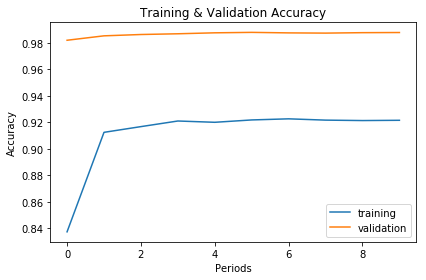

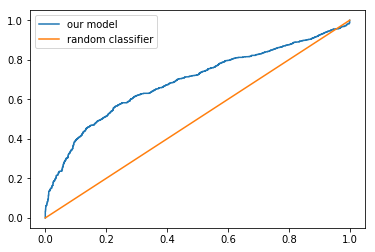

AUC
0.6898457809595493


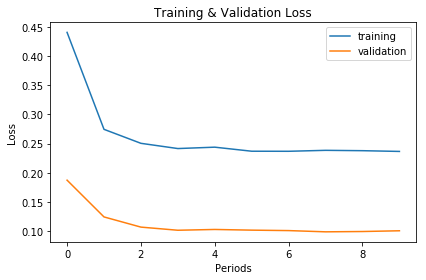

(0.9878333, 0.1004137060377333)

In [94]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_ngram_model(data,
                      learning_rate=0.001,
                      epochs=10,
                      batch_size=64,
                      layers=4,
                      units=4,
                      dropout_rate=0.4)


In [13]:
def make_prediction(tweet_text):
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
#     print(tweet_text)
    x_train, x_val = ngram_vectorize(
        training_examples, training_targets, tweet_text)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.predict(x_val)
    print(prediction)

In [14]:
def evaluate_model():
    x_train, test_set = ngram_vectorize(training_examples, training_targets, test_examples)
#     x_train, test_labels = ngram_vectorize(training_examples, training_targets, test_targets)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.evaluate(test_set, test_targets)
    
    

In [15]:
def roc_curve(history):
    x_train, test_set = ngram_vectorize(training_examples, training_targets, test_examples)
    fake_detector = load_model('twitter_model.h5')
    prediction = fake_detector.predict(test_set)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_targets, prediction)
    plt.plot(false_positive_rate, true_positive_rate, label="our model")
    plt.plot([0, 1], [0, 1], label="random classifier")
    _ = plt.legend(loc=2)
    plt.show()
    auc = metrics.roc_auc_score(test_targets,prediction)
    print("AUC")
    print(auc)

In [95]:
evaluate_model()

8000/8000 [==============================] - 2s 293us/sample - loss: 1.2893 - acc: 0.8173


In [ ]:
# SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK SECTION BREAK 

In [17]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [18]:
def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [32]:
def evaluate_seq_model():
    x_train, test_set, word_index = sequence_vectorize(test_examples, test_examples)
    fake_detector = load_model('twitter_model_seq.h5')
    prediction = fake_detector.evaluate(test_set, test_targets)

In [26]:
def train_seq_model(data,
                      learning_rate,
                      epochs,
                      batch_size,
                      layers,
                      units,
                      dropout_rate):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = explore_data.get_num_classes(train_labels)
    num_classes = 2
#     unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
#     if len(unexpected_labels):
#         raise ValueError('Unexpected label values found in the validation set:'
#                          ' {unexpected_labels}. Please make sure that the '
#                          'labels in the validation set are in the same range '
#                          'as training labels.'.format(
#                              unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
        train_texts, val_texts)
    print(x_train.shape)
    print(x_val.shape)
    
    # Create model instance.
    model = sepcnn_model(blocks=layers, filters=4, kernel_size=4, embedding_dim=200, dropout_rate=dropout_rate, pool_size=3, input_shape=x_train.shape[1:], 
                         num_classes=2, num_features=TOP_K)
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
#     print('Validation accuracy: {acc}, loss: {loss}'.format(
#             acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    
    # Compute training and validation loss.
    
    # Plot Results
    plot_res(history)
    roc_curve(history)
    plot_loss(history)
    
    # Save model.
    model.save('twitter_model_seq.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [ ]:
data = (training_examples, training_targets),(validation_examples, validation_targets)
train_seq_model(data=data,
                      learning_rate=0.01,
                      epochs=10,
                      batch_size=64,
                      layers=2,
                      units=1,
                      dropout_rate=0.2)

(80000, 94)
(18000, 94)
Train on 80000 samples, validate on 18000 samples
Epoch 1/10
 - 97s - loss: 0.1054 - acc: 0.9562 - val_loss: 0.0401 - val_acc: 0.9883
Epoch 2/10
 - 93s - loss: 0.0367 - acc: 0.9894 - val_loss: 0.0439 - val_acc: 0.9886
Epoch 3/10
 - 97s - loss: 0.0271 - acc: 0.9917 - val_loss: 0.0438 - val_acc: 0.9887
Epoch 4/10
 - 96s - loss: 0.0230 - acc: 0.9933 - val_loss: 0.0433 - val_acc: 0.9889
Epoch 5/10
 - 92s - loss: 0.0188 - acc: 0.9942 - val_loss: 0.0459 - val_acc: 0.9886
Epoch 6/10
 - 93s - loss: 0.0145 - acc: 0.9954 - val_loss: 0.0474 - val_acc: 0.9887
Epoch 7/10


In [ ]:
evaluate_seq_model()